In [ ]:
import urllib
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import openapi

: 

In [ ]:
import requests

url = 'http://apis.data.go.kr/B551172/Kidney12/kiHeartByType'

# ✅ 기본 파라미터 설정 (numOfRows를 정수로 변경)
params = {
    'serviceKey': 'PwfNqgN7hal2oSaDMz96GOgjRcDcPrZUybaows5KKV1Xa0uMKVhAbb/e2y78IJMwQ+mHPTsZgjBVqkk54niRUA==',
    'type': 'json',
    'numOfRows': 100,  # 🔹 문자열이 아닌 정수로 변경
    'centerNm': '국립암센터',
    'fromYear': '2010',
    'toYear': '2023',
    'pageNo': 1
}

all_data = []

# 1️⃣ 먼저 첫 번째 요청을 보내서 totalCount 확인
response = requests.get(url, params=params)

if response.status_code == 200:
    resp_dict = response.json()

    # 🔹 totalCount가 없을 경우 기본값 0으로 설정 (오류 방지)
    total_count = int(resp_dict.get('totalCount', 0) or 0)  
    items_per_page = params['numOfRows']  
    total_pages = (total_count // items_per_page) + (1 if total_count % items_per_page else 0)

    print(f"📌 총 데이터 개수: {total_count}, 가져올 페이지 수: {total_pages}")

    # ✅ 데이터가 없을 경우 메시지 출력 후 종료
    if total_count == 0:
        print("⚠️ 가져올 데이터가 없습니다.")
    else:
        # 2️⃣ total_pages 만큼 반복하여 모든 데이터를 가져오기
        for i in range(1, total_pages + 1):
            page_params = params.copy()  # 🔹 원본 params 보호
            page_params['pageNo'] = i  

            response = requests.get(url, params=page_params)

            if response.status_code == 200:
                resp_dict = response.json()
                items = resp_dict.get('items', [])  # 🔹 데이터가 없을 경우 빈 리스트 반환
                all_data.extend(items)
                print(f"📄 페이지 {i}/{total_pages} 처리 완료! (누적 {len(all_data)}개)")
            else:
                print(f"❌ 데이터 요청 실패 (페이지 {i})")

        print(f"✅ 총 {len(all_data)}개의 데이터 수집 완료!")

else:
    print(f"❌ API 요청 실패 - HTTP 상태 코드: {response.status_code}")

df_heart = pd.DataFrame(all_data)

📌 총 데이터 개수: 1415, 가져올 페이지 수: 15
📄 페이지 1/15 처리 완료! (누적 100개)
📄 페이지 2/15 처리 완료! (누적 200개)
📄 페이지 3/15 처리 완료! (누적 300개)
📄 페이지 4/15 처리 완료! (누적 400개)
📄 페이지 5/15 처리 완료! (누적 500개)
📄 페이지 6/15 처리 완료! (누적 600개)
📄 페이지 7/15 처리 완료! (누적 700개)
📄 페이지 8/15 처리 완료! (누적 800개)
📄 페이지 9/15 처리 완료! (누적 900개)
📄 페이지 10/15 처리 완료! (누적 1000개)
📄 페이지 11/15 처리 완료! (누적 1100개)
📄 페이지 12/15 처리 완료! (누적 1200개)
📄 페이지 13/15 처리 완료! (누적 1300개)
📄 페이지 14/15 처리 완료! (누적 1400개)
📄 페이지 15/15 처리 완료! (누적 1415개)
✅ 총 1415개의 데이터 수집 완료!


In [9]:
df_heart = df_heart.iloc[:, [1,2,3,4,5,-2]]
df_heart

,centerNm,critYr,ptAge,ptSexCd,statsTrgtNm,ptCntNmvl
0,국립암센터,2010,65,M,N,6
1,국립암센터,2017,71,M,N,1
2,국립암센터,2017,73,F,Y,1
3,국립암센터,2021,40,F,N,1
4,국립암센터,2011,40,F,N,2
...,...,...,...,...,...,...
1410,국립암센터,2010,34,F,N,1
1411,국립암센터,2015,55,M,N,1
1412,국립암센터,2015,41,F,N,1
1413,국립암센터,2012,78,F,N,1


In [10]:
df_heart.rename(columns={'centerNm':'센터 이름', 'critYr':'기준 년도', 'statsTrgtNm':'심장질환 병력 여부','ptAge':'연령' ,'ptSexCd':'성별', 'ptCntNmvl': '환자수'}, inplace=True)
df_heart

,센터 이름,기준 년도,연령,성별,심장질환 병력 여부,환자수
0,국립암센터,2010,65,M,N,6
1,국립암센터,2017,71,M,N,1
2,국립암센터,2017,73,F,Y,1
3,국립암센터,2021,40,F,N,1
4,국립암센터,2011,40,F,N,2
...,...,...,...,...,...,...
1410,국립암센터,2010,34,F,N,1
1411,국립암센터,2015,55,M,N,1
1412,국립암센터,2015,41,F,N,1
1413,국립암센터,2012,78,F,N,1


In [11]:
df_heart['환자수'] = pd.to_numeric(df_heart['환자수'], errors='coerce')

df_heart['환자수'] = df_heart['환자수'].fillna(0).astype(int)

heart_count = df_heart.groupby(df_heart['심장질환 병력 여부'].fillna('무응답'))['환자수'].sum()

print(heart_count)

심장질환 병력 여부
N      1685
Y      1030
무응답      35
Name: 환자수, dtype: int64


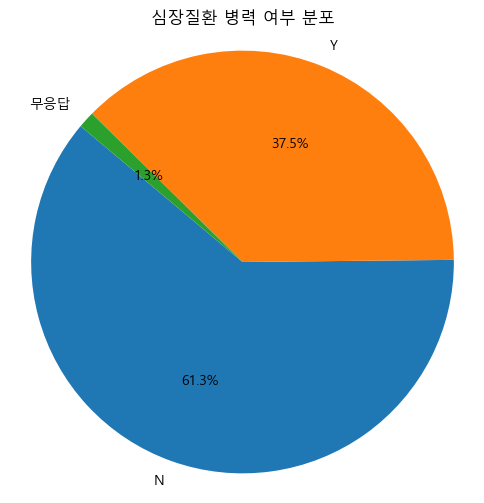

In [12]:
import matplotlib.font_manager as fm

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(heart_count.values, labels=heart_count.index, autopct='%1.1f%%', startangle=140)
plt.title('심장질환 병력 여부 분포')
plt.axis('equal')
plt.show()